In [2]:
import requests
import json
import pandas as pd
import string
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm

In [3]:
def getPlayerContractData(df_players,cap_table):
    "Returns a dictionary with key corresponding to player and value corresponding to dictionary of two tables:"
    "The first table is contract specific data and player-immutable data, and the second table is more detailed statistics"
    dict_contracts = {}
    
    for p in list(df_players.index):
        first,last = p.split(' ')[0],p.split(' ')[1]
        url = f'https://www.capfriendly.com/players/{first}-{last}'
        response = requests.get(url)
        try:
            tables = pd.read_html(response.text)
        except ValueError:
            continue
        
        if len(tables) < 1:
            continue
        dict_player = {}
        df_allContracts = pd.DataFrame()
        for t in (tables[:-1]):
            t_new = t.iloc[1:,[0,2]]
            contract_length = t_new.shape[0]-1
            start_year = (int(t_new.iloc[0,0].split('-')[0]) if isinstance(t_new.iloc[0,0].split('-')[0],str) else None)
            total_value = (int(t_new.iloc[-1,1].replace('$','').replace(',','')) if isinstance(t_new.iloc[-1,1],str) else None)
            df_allContracts.loc[start_year,'Value'] = total_value
            df_allContracts.loc[start_year,'Length'] = contract_length

        df_allContracts = df_allContracts.dropna()
        df_allContracts['AAV'] = (df_allContracts['Value']/df_allContracts['Length'])
        for y in list(df_allContracts.index):
            df_allContracts.loc[y,'Contract Age'] = y-df_players.loc[p,'birthYear']
            if y >= 2005:
                df_allContracts.loc[y,'Cap Hit'] = df_allContracts.loc[y,'AAV']/cap_table.loc[y,'UPPER LIMIT']
            else:
                df_allContracts.loc[y,'Cap Hit'] = 0
        df_allContracts = df_allContracts[df_allContracts['Cap Hit'] > 0]
        
        df_allContracts['Position'] = df_players.loc[p,'Position']
        df_allContracts['Nationality'] = df_players.loc[p,'nationality']
        df_allContracts['Height'] = df_players.loc[p,'height']
        df_allContracts['Overall Pick'] = df_players.loc[p,'Overall Pick']
        
        summary_table = tables[-1]
        summary_table = summary_table[~summary_table['SEASON'].isna()].iloc[:-1,:]
        summary_table = summary_table[summary_table['LEAGUE'] == 'NHL']
        summary_table['SEASON ENDING'] = summary_table['SEASON'].apply(lambda x: int(x.split('-')[0][:2]+x.split('-')[1]))
        summary_table = summary_table.set_index('SEASON ENDING')

        dict_player['Summary'] = df_allContracts
        dict_player['Stats'] = summary_table
        dict_contracts[p] = dict_player
        
    return dict_contracts

In [4]:
def getDataTable_g(dict_players):
    
    df_final = pd.DataFrame()
    
    for p in list(dict_players.keys()):
        
        df_stat_summary = dict_players[p]['Stats'].drop(columns=['SEASON','TEAM','LEAGUE','Unnamed: 3','Unnamed: 7','Unnamed: 15','PLAYOFFS.1','PLAYOFFS'])
        df_stat_summary.columns = ['GAMES_PLAYED','GAA','Sv%','GP_PLAYOFF','GAA_PLAYOFF','Sv%_PLAYOFF','GA60','xGA60','GSAx60','GA60_PLAYOFF',
                                   'xGA60_PLAYOFF','GSAx60_PLAYOFF']
        df_stat_summary = df_stat_summary.fillna(0)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)

        df_contract_allData = dict_players[p]['Summary'].copy()

        df_data = pd.DataFrame()

        for y in list(dict_players[p]['Summary'].index):
            ct_years = [y,y-1,y-2]
            ct_year_symbols = ['_t','_t1','_t2']
            ls_temp = []
            t_count = 0
            for t in ct_years:
                if t in df_stat_summary.index:
                    row_t = df_stat_summary.loc[t]
                    row_t.index = [c + ct_year_symbols[ct_years.index(t)] for c in row_t.index]
                    df_temp = pd.DataFrame(row_t).T
                    df_temp.index = [y]
                    ls_temp.append(df_temp)
                    t_count += 1
                else:
                    df_temp = pd.DataFrame(0,columns = [c + ct_year_symbols[ct_years.index(t)] for c in df_stat_summary.columns],index=[y])
                    ls_temp.append(df_temp)

            if t_count > 0:
                avg = (np.array(ls_temp[0].values)+np.array(ls_temp[1].values)+(ls_temp[2].values))/t_count
                avg_columns = [c + '_avg' for c in df_stat_summary.columns]
                avg_df = pd.DataFrame(avg,columns=avg_columns,index=[y])
                df_y = pd.concat([ls_temp[0],ls_temp[1],ls_temp[2],avg_df],axis=1)

                if df_data.empty:
                    df_data = df_y
                else:
                    df_data = pd.concat([df_data,df_y],axis=0)

            else:
                df_contract_allData = df_contract_allData.drop(labels=[y],axis=0)

        df_final_player = df_contract_allData.merge(df_data,left_index=True,right_index=True)
        
        if df_final.empty:
            df_final = df_final_player
        else:
            df_final = pd.concat([df_final,df_final_player],axis=0)
    
    return df_final

In [5]:
def getDataTable_ng(dict_contracts):
    
    df_final = pd.DataFrame()
    
    for p in list(dict_contracts.keys()):
        df_stat_summary = dict_contracts[p]['Stats'].drop(columns=['SEASON','TEAM','LEAGUE','Unnamed: 3','Unnamed: 10','Unnamed: 25','Unnamed: 33','PLAYOFFS',
                                                                    'G.3','G.2'])
        df_stat_summary.columns = ['GAMES_PLAYED','G','A','P','PLUS_MINUS','PIM','GP_PLAYOFF','G_PLAYOFF','A_PLAYOFF','P_PLAYOFF','PLUS_MINUS_PLAYOFF',
                                   'PIM_PLAYOFF','TOI','ixG','xG±/60','RelxG±/60', 'C±/60', 'RelC±/60','TOI_PLAYOFF','ixG_PLAYOFF','xG±/60_PLAYOFF',
                                   'RelxG±/60_PLAYOFF','C±/60_PLAYOFF','RelC±/60_PLAYOFF']
        df_stat_summary = df_stat_summary.fillna(0)
        df_stat_summary['TOI'] = df_stat_summary['TOI'].apply(lambda x: (x.split(':')))
        df_stat_summary['TOI'] = df_stat_summary['TOI'].apply(lambda x: int(x[0])+(pd.to_numeric(x[1])/60) if len(x) > 1 else 0)
        df_stat_summary['TOI_PLAYOFF'] = df_stat_summary['TOI_PLAYOFF'].apply(lambda x: (x.split(':')))
        df_stat_summary['TOI_PLAYOFF'] = df_stat_summary['TOI_PLAYOFF'].apply(lambda x: int(x[0])+(pd.to_numeric(x[1])/60) if len(x) > 1 else 0)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)

        df_stat_summary['G_PG'] = pd.to_numeric(df_stat_summary['G'])/pd.to_numeric(df_stat_summary['GAMES_PLAYED'])
        df_stat_summary['P_PG'] = pd.to_numeric(df_stat_summary['P'])/pd.to_numeric(df_stat_summary['GAMES_PLAYED'])
        df_stat_summary['PIM_PG'] = pd.to_numeric(df_stat_summary['PIM'])/pd.to_numeric(df_stat_summary['GAMES_PLAYED'])

        df_stat_summary['G_PG_PLAYOFF'] = df_stat_summary.apply(lambda row: (row.G_PLAYOFF/row.GP_PLAYOFF if row.GP_PLAYOFF > 0 else 0),axis=1)
        df_stat_summary['P_PG_PLAYOFF'] = df_stat_summary.apply(lambda row: (row.P_PLAYOFF/row.GP_PLAYOFF if row.GP_PLAYOFF > 0 else 0),axis=1)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)
        
        df_contract_allData = dict_contracts[p]['Summary'].copy()

        df_data = pd.DataFrame()

        for y in list(dict_contracts[p]['Summary'].index):
            ct_years = [y,y-1,y-2]
            ct_year_symbols = ['_t','_t1','_t2']
            ls_temp = []
            t_count = 0
            for t in ct_years:
                if t in df_stat_summary.index:
                    row_t = df_stat_summary.loc[t]
                    row_t.index = [c + ct_year_symbols[ct_years.index(t)] for c in row_t.index]
                    df_temp = pd.DataFrame(row_t).T
                    df_temp.index = [y]
                    ls_temp.append(df_temp)
                    t_count += 1
                else:
                    df_temp = pd.DataFrame(0,columns = [c + ct_year_symbols[ct_years.index(t)] for c in df_stat_summary.columns],index=[y])
                    ls_temp.append(df_temp)

            if t_count > 0:
                avg = (np.array(ls_temp[0].values)+np.array(ls_temp[1].values)+(ls_temp[2].values))/t_count
                avg_columns = [c + '_avg' for c in df_stat_summary.columns]
                avg_df = pd.DataFrame(avg,columns=avg_columns,index=[y])
                df_y = pd.concat([ls_temp[0],ls_temp[1],ls_temp[2],avg_df],axis=1)

                if df_data.empty:
                    df_data = df_y
                else:
                    df_data = pd.concat([df_data,df_y],axis=0)

            else:
                df_contract_allData = df_contract_allData.drop(labels=[y],axis=0)

        df_final_player = df_contract_allData.merge(df_data,left_index=True,right_index=True)
        
        if df_final.empty:
            df_final = df_final_player
        else:
            df_final = pd.concat([df_final,df_final_player],axis=0)
    
    return df_final

In [7]:
test = requests.get('https://statsapi.web.nhl.com/api/v1/teams')

In [8]:
teams = json.loads(test.text)['teams']

In [9]:
len(teams)

32

In [10]:
teams[0]

{'id': 1,
 'name': 'New Jersey Devils',
 'link': '/api/v1/teams/1',
 'venue': {'name': 'Prudential Center',
  'link': '/api/v1/venues/null',
  'city': 'Newark',
  'timeZone': {'id': 'America/New_York', 'offset': -4, 'tz': 'EDT'}},
 'abbreviation': 'NJD',
 'teamName': 'Devils',
 'locationName': 'New Jersey',
 'firstYearOfPlay': '1982',
 'division': {'id': 18,
  'name': 'Metropolitan',
  'nameShort': 'Metro',
  'link': '/api/v1/divisions/18',
  'abbreviation': 'M'},
 'conference': {'id': 6, 'name': 'Eastern', 'link': '/api/v1/conferences/6'},
 'franchise': {'franchiseId': 23,
  'teamName': 'Devils',
  'link': '/api/v1/franchises/23'},
 'shortName': 'New Jersey',
 'officialSiteUrl': 'http://www.newjerseydevils.com/',
 'franchiseId': 23,
 'active': True}

In [11]:
team_ids = {t['name']:t['id'] for t in teams}

To get a list of players that will be eligible for data, we can look at current team rosters and see who played in the most recent NHL season. Though it might make sense to extend the list of players to all those who have been on teams in the salary cap era, it is more likely that data should be trained on the players who define the relevant market.

In [12]:
# get roster for each team
dict_teamRosters = {}

for team in list(team_ids.keys()):
    team_id = team_ids[team]
    request_roster = requests.get(f'https://statsapi.web.nhl.com/api/v1/teams/{team_id}/roster')
    roster = json.loads(request_roster.text)
    df_roster = pd.DataFrame()
    for r in roster['roster']:
        player_id = r['person']['id']
        df_roster.loc[player_id,'Name'] = r['person']['fullName']
        df_roster.loc[player_id,'Position'] = r['position']['code']
        if 'jerseyNumber' in list(r.keys()):
             df_roster.loc[player_id,'JerseyNumber'] = r['jerseyNumber']
    dict_teamRosters[team] = df_roster

In [13]:
for df_team in list(dict_teamRosters.values()):
    for i in list(df_team.index):
        player_request = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{i}')
        player = json.loads(player_request.text)['people'][0]
        df_team.loc[i,'birthDate'] = player['birthDate']
        df_team.loc[i,'currentAge'] = player['currentAge']
        df_team.loc[i,'nationality'] = player['nationality']
        
        height_list = [int(player['height'].split(' ')[i].translate(str.maketrans('','',string.punctuation))) for i in [0,1]]
        df_team.loc[i,'height'] = height_list[0]*12+height_list[1]
        df_team.loc[i,'weight'] = player['weight']
        df_team.loc[i,'alternateCaptain'] = player['alternateCaptain']
        df_team.loc[i,'captain'] = player['captain']

With the organization of the NHL API by team, we can use the dataframes constructed for each team's roster to create one large 'player information' dataframe, which we can continue to populate with information about the player that is considered 'timeless,' or data that does not vary by season. While it is possible that a player's weight fluctuates over the course of their career (and in fact probably does), we will make the assumption that height does not. Moreover, we will assume that a player continues in the same position for the course of their career.

In [14]:
df_players = pd.DataFrame()
for df_team in list(dict_teamRosters.values()):
    if df_players.empty:
        df_players = df_team
    else:
        df_players = pd.concat([df_players,df_team],axis=0)
df_players = df_players.set_index('Name')

In [15]:
# get draft data
start_year = 2000
current_year = 2023

df_draft = pd.DataFrame()

while (start_year < current_year):
    draft_req = requests.get(f'https://statsapi.web.nhl.com/api/v1/draft/{start_year}')
    draft = json.loads(draft_req.text)['drafts'][0]
    for r in (draft['rounds']):
        for p in (r['picks']):
            player = p['prospect']['fullName']
            pick_overall = p['pickOverall']
            df_draft.loc[player,'Overall Pick'] = pick_overall
            df_draft.loc[player,'Year'] = start_year
    start_year += 1

A player's draft record is also something that does not change over the course of the career - in fact it only happens once - so we will also populate the players dataframe with that information. For the rare case of undrafted players, there is some question of how they should be treated - we will start by assuming a median number, and then re-evaluate.

In [16]:
df_draft_lower = df_draft.copy()
df_draft_lower.index = pd.Series(df_draft.index).apply(lambda x: x.lower())

for p in list(df_players.index):
    p_lower = p.lower()
    if p_lower in df_draft_lower.index:
        df_players.loc[p,'Overall Pick'] = df_draft_lower.loc[p_lower,'Overall Pick']
    else:
        df_players.loc[p,'Overall Pick'] = df_draft_lower['Overall Pick'].median()

In [17]:
# currently two players have the same name - need to drop these until using player id 
# remove Sebastian Aho, Eric Robinson, James Reimer
df_players = df_players.drop(labels=['Sebastian Aho','Eric Robinson','James Reimer'])

In [18]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, Jonathan Bernier to Jesper Froden
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Position          865 non-null    object 
 1   JerseyNumber      856 non-null    object 
 2   birthDate         865 non-null    object 
 3   currentAge        865 non-null    float64
 4   nationality       865 non-null    object 
 5   height            865 non-null    float64
 6   weight            865 non-null    float64
 7   alternateCaptain  865 non-null    object 
 8   captain           865 non-null    object 
 9   Overall Pick      865 non-null    float64
dtypes: float64(4), object(6)
memory usage: 74.3+ KB


In [19]:
df_players['birthYear'] = df_players['birthDate'].apply(lambda x: pd.to_numeric(x.split('-')[0]))

In [20]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, Jonathan Bernier to Jesper Froden
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Position          865 non-null    object 
 1   JerseyNumber      856 non-null    object 
 2   birthDate         865 non-null    object 
 3   currentAge        865 non-null    float64
 4   nationality       865 non-null    object 
 5   height            865 non-null    float64
 6   weight            865 non-null    float64
 7   alternateCaptain  865 non-null    object 
 8   captain           865 non-null    object 
 9   Overall Pick      865 non-null    float64
 10  birthYear         865 non-null    int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 81.1+ KB


In [21]:
df_players.to_csv('api_players_data.csv')

In [22]:
# get stats for each player
player_stats = {}

for team in ['Seattle Kraken']:
    df_team = dict_teamRosters[team]
    for player_id in list(df_team.index):
        start_season = 2023
        active_in_season = True
        dict_player = {}
        while(active_in_season):
            season = f'{start_season-1}{start_season}'
            player_request = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{player_id}/stats?stats=statsSingleSeason&season={season}')
            stats = json.loads(player_request.text)
            if not (stats['stats'][0]['splits']):
                active_in_season = False
            else:
                dict_player[season] = stats['stats'][0]['splits'][0]['stat']
                start_season -= 1
        player_stats[player_id] = dict_player

In [24]:
# get salary cap data
url_cap = 'https://www.capfriendly.com/salary-cap'
response_cap = requests.get(url_cap)
tables_cap = pd.read_html(response_cap.text)[0]
tables_cap['SEASON'] = tables_cap['SEASON'].apply(lambda x: int(x.split('-')[0]))
cap_table = tables_cap.set_index('SEASON').drop(columns=['CONFIRMED','% CHANGE']).applymap(lambda x: int(x.replace('$','').replace(',','')))

Now we will start incorporating salary data for players, using a couple of bespoke functions to gather and clean data that will be used to make the dataframe on which the models can be run. To do this, we need to split the players into goalies and non-goalies - this is because goalie metrics are an entirely diffrent set of statistics. 

In [25]:
df_players_g = df_players[df_players['Position'] == 'G']
df_players_ng = df_players[df_players['Position'] != 'G']

In [26]:
df_players_g['Position'].unique()

array(['G'], dtype=object)

In [27]:
df_players_ng['Position'].unique()

array(['D', 'L', 'C', 'R'], dtype=object)

In [28]:
dict_contracts_g = getPlayerContractData(df_players_g,cap_table)

ImportError: html5lib not found, please install it

In [1237]:
dataTable_g = getDataTable_g(dict_contracts_g)

In [1238]:
dataTable_g.head()

,Value,Length,AAV,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,GAMES_PLAYED_t,...,Sv%_avg,GP_PLAYOFF_avg,GAA_PLAYOFF_avg,Sv%_PLAYOFF_avg,GA60_avg,xGA60_avg,GSAx60_avg,GA60_PLAYOFF_avg,xGA60_PLAYOFF_avg,GSAx60_PLAYOFF_avg
2021,8250000.0,2.0,4125000.0,33.0,0.050613,G,CAN,72.0,11.0,24.0,...,0.908333,0.000000,0.000000,0.000000,2.643333,2.640000,-0.003333,0.00,0.000000,0.000000
2011,2500000.0,2.0,1250000.0,23.0,0.019440,G,CAN,72.0,11.0,25.0,...,0.935000,0.000000,0.000000,0.000000,1.755000,2.155000,0.400000,0.00,0.000000,0.000000
2013,5800000.0,2.0,2900000.0,25.0,0.045101,G,CAN,72.0,11.0,14.0,...,0.914667,0.333333,0.000000,0.333333,1.990000,1.916667,-0.073333,0.00,0.236667,0.236667
2015,8300000.0,2.0,4150000.0,27.0,0.058123,G,CAN,72.0,11.0,58.0,...,0.918667,0.333333,0.000000,0.333333,2.083333,2.273333,0.190000,0.00,0.236667,0.236667
2017,2750000.0,1.0,2750000.0,29.0,0.036667,G,CAN,72.0,11.0,39.0,...,0.911667,1.333333,1.096667,0.291000,2.473333,2.356667,-0.116667,0.95,0.823333,-0.126667


In [1247]:
dict_contracts_ng = getPlayerContractData(df_players_ng,cap_table)

In [1257]:
dataTable_ng = getDataTable_ng(dict_contracts_ng)

Brendan Smith
Tomas Tatar
Erik Haula
Ondrej Palat
Dougie Hamilton
Damon Severson
Miles Wood
Ryan Graves
Curtis Lazar
Jonas Siegenthaler
Timo Meier
John Marino
Jesper Bratt
Nathan Bastian
Michael McLeod
Nico Hischier
Jesper Boqvist
Kevin Bahl
Yegor Sharangovich
Nolan Foote
Jack Hughes
Tyce Thompson
Dawson Mercer
Alexander Holtz
Luke Hughes
Topias Vilen
Simon Nemec
Brian Halonen
Oliver Wahlstrom
Zach Parise
Cal Clutterbuck
Josh Bailey
Matt Martin
Kyle Palmieri
Casey Cizikas
Anders Lee
Brock Nelson
Jean-Gabriel Pageau
Scott Mayfield
Adam Pelech
Hudson Fasching
Bo Horvat
Ryan Pulock
Ross Johnston
Pierre Engvall
Mathew Barzal
Parker Wotherspoon
Noah Dobson
Alexander Romanov
Samuel Bolduc
Simon Holmstrom
Patrick Kane
Chris Kreider
Vladimir Tarasenko
Vincent Trocheck
Mika Zibanejad
Barclay Goodrow
Jacob Trouba
Jimmy Vesey
Tyler Motte
Ben Harpur
Artemi Panarin
Niko Mikkola
Adam Fox
Ryan Lindgren
Filip Chytil
Kaapo Kakko
Braden Schneider
Cam Atkinson
Ryan Ellis
Sean Couturier
Justin Braun
Nicol

In [1262]:
dataTable_ng.shape

(1598, 125)

In [1263]:
dataTable_ng.head()

,Value,Length,AAV,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,GAMES_PLAYED_t,...,ixG_PLAYOFF_avg,xG±/60_PLAYOFF_avg,RelxG±/60_PLAYOFF_avg,C±/60_PLAYOFF_avg,RelC±/60_PLAYOFF_avg,G_PG_avg,P_PG_avg,PIM_PG_avg,G_PG_PLAYOFF_avg,P_PG_PLAYOFF_avg
2022,2200000.0,2.0,1100000.0,33.0,0.013333,D,CAN,74.0,27.0,45.0,...,0.176667,-0.430000,-0.070000,-2.03,1.926667,0.080481,0.171714,1.155332,0.023810,0.095238
2013,2525000.0,2.0,1262500.0,24.0,0.019635,D,CAN,74.0,27.0,34.0,...,0.310000,-0.200000,-0.170000,2.06,0.700000,0.035714,0.367647,0.993697,0.071429,0.178571
2015,5500000.0,2.0,2750000.0,26.0,0.038515,D,CAN,74.0,27.0,76.0,...,0.436667,-0.210000,-0.170000,4.95,2.456667,0.041018,0.224651,0.970436,0.047619,0.119048
2017,17400000.0,4.0,4350000.0,28.0,0.058000,D,CAN,74.0,27.0,33.0,...,0.170000,0.760000,0.673333,9.24,6.873333,0.053619,0.186888,0.969722,0.000000,0.111111
2021,800000.0,1.0,800000.0,32.0,0.009816,D,CAN,74.0,27.0,48.0,...,0.036667,-0.183333,0.163333,-2.71,2.683333,0.072015,0.181238,1.264326,0.000000,0.000000


In [1265]:
dataTable_g.shape

(235, 57)

In [1207]:
import seaborn as sns

<AxesSubplot: xlabel='GAMES_PLAYED_avg', ylabel='Cap Hit'>

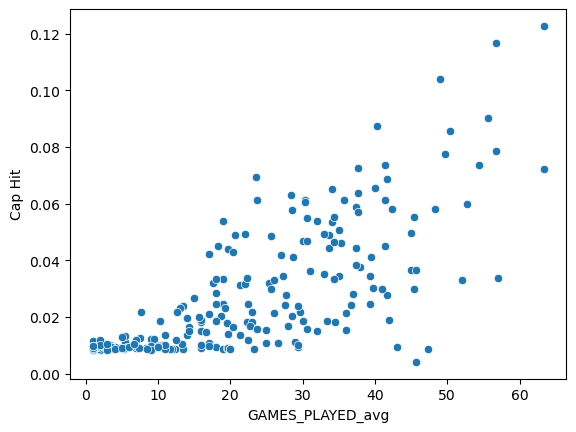

In [1213]:
sns.scatterplot(x=dataTable_g['GAMES_PLAYED_avg'],y=dataTable_g['Cap Hit'])

In [1]:
import statsmodels

## specification

Data - players stats, biography, info for each season in a dictionary
Contract data - data for each player in a table

player data structure - find player similarity by average career statistics, and then by trajectory

In [ ]:
## specification

Date 

In [ ]:
https://statsapi.web.nhl.com/api/v1/draft/YEAR